In [ ]:
from llava.model.builder import load_pretrained_model
from llava.mm_utils import get_model_name_from_path
from llava.eval.run_llava import eval_model

from IPython.display import display
from PIL import Image # Import the Image class from PIL module

# Fikołki by pozbyć się błędów, przy ładowaniu modelu więcej niż raz (uruchamić __TYLKO__ raz)
Przy drugim i kolejnych uruchomieniach `load_pretrained_model` zwróci błąd i wymagany jest reset środowisko

In [4]:
model_path = "liuhaotian/llava-v1.5-7b"

tokenizer, model, image_processor, context_len = load_pretrained_model(
    model_path=model_path,
    model_base=None,
    model_name=get_model_name_from_path(model_path)
)

c:\Users\Wisnia\AppData\Local\Programs\Python\Python310\lib\site-packages\huggingface_hub\file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
You are using a model of type llava to instantiate a model of type llava_llama. This is not supported for all configurations of models and can yield errors.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

c:\Users\Wisnia\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [5]:
import argparse
import torch

from llava.constants import (
    IMAGE_TOKEN_INDEX,
    DEFAULT_IMAGE_TOKEN,
    DEFAULT_IM_START_TOKEN,
    DEFAULT_IM_END_TOKEN,
    IMAGE_PLACEHOLDER,
)
from llava.conversation import conv_templates, SeparatorStyle
from llava.model.builder import load_pretrained_model
from llava.utils import disable_torch_init
from llava.mm_utils import (
    process_images,
    tokenizer_image_token,
    get_model_name_from_path,
)

from PIL import Image

import requests
from PIL import Image
from io import BytesIO
import re

def image_parser(args):
    out = args.image_file.split(args.sep)
    return out


def load_image(image_file):
    if image_file.startswith("http") or image_file.startswith("https"):
        response = requests.get(image_file)
        image = Image.open(BytesIO(response.content)).convert("RGB")
    else:
        image = Image.open(image_file).convert("RGB")
    return image


def load_images(image_files):
    out = []
    for image_file in image_files:
        image = load_image(image_file)
        out.append(image)
    return out


def my_eval_model(args, tokenizer, model, image_processor, context_len):
    # Model
    disable_torch_init()

    model_name = get_model_name_from_path(args.model_path)
    # tokenizer, model, image_processor, context_len = load_pretrained_model(
    #     args.model_path, args.model_base, model_name
    # )

    qs = args.query
    image_token_se = DEFAULT_IM_START_TOKEN + DEFAULT_IMAGE_TOKEN + DEFAULT_IM_END_TOKEN
    if IMAGE_PLACEHOLDER in qs:
        if model.config.mm_use_im_start_end:
            qs = re.sub(IMAGE_PLACEHOLDER, image_token_se, qs)
        else:
            qs = re.sub(IMAGE_PLACEHOLDER, DEFAULT_IMAGE_TOKEN, qs)
    else:
        if model.config.mm_use_im_start_end:
            qs = image_token_se + "\n" + qs
        else:
            qs = DEFAULT_IMAGE_TOKEN + "\n" + qs

    if "llama-2" in model_name.lower():
        conv_mode = "llava_llama_2"
    elif "mistral" in model_name.lower():
        conv_mode = "mistral_instruct"
    elif "v1.6-34b" in model_name.lower():
        conv_mode = "chatml_direct"
    elif "v1" in model_name.lower():
        conv_mode = "llava_v1"
    elif "mpt" in model_name.lower():
        conv_mode = "mpt"
    else:
        conv_mode = "llava_v0"

    if args.conv_mode is not None and conv_mode != args.conv_mode:
        print(
            "[WARNING] the auto inferred conversation mode is {}, while `--conv-mode` is {}, using {}".format(
                conv_mode, args.conv_mode, args.conv_mode
            )
        )
    else:
        args.conv_mode = conv_mode

    conv = conv_templates[args.conv_mode].copy()
    conv.append_message(conv.roles[0], qs)
    conv.append_message(conv.roles[1], None)
    prompt = conv.get_prompt()

    image_files = image_parser(args)
    images = load_images(image_files)
    image_sizes = [x.size for x in images]
    images_tensor = process_images(
        images,
        image_processor,
        model.config
    ).to(model.device, dtype=torch.float16)

    input_ids = (
        tokenizer_image_token(prompt, tokenizer, IMAGE_TOKEN_INDEX, return_tensors="pt")
        .unsqueeze(0)
        .cuda()
    )

    with torch.inference_mode():
        output_ids = model.generate(
            input_ids,
            images=images_tensor,
            image_sizes=image_sizes,
            do_sample=True if args.temperature > 0 else False,
            temperature=args.temperature,
            top_p=args.top_p,
            num_beams=args.num_beams,
            max_new_tokens=args.max_new_tokens,
            use_cache=True,
        )

    outputs = tokenizer.batch_decode(output_ids, skip_special_tokens=True)[0].strip()
    print(outputs)

In [10]:
def show_image(image_path):
    img = Image.open(image_path)
    display(img)

In [22]:
def get_explanation(prompt, image_file, temperature=0.2, top_p=0.7, max_new_tokens=512):
    show_image(image_file)

    model_path = "liuhaotian/llava-v1.5-7b"

    args = type('Args', (), {
        "model_path": model_path,
        "model_base": None,
        "model_name": get_model_name_from_path(model_path),
        "query": prompt,
        "conv_mode": None,
        "image_file": image_file,
        "sep": ",",
        "temperature": temperature,
        "top_p": top_p,
        "num_beams": 1,
        "max_new_tokens": max_new_tokens
    })()

    my_eval_model(args, tokenizer, model, image_processor, context_len)

# Pregenerated Examples

In [8]:
protos_path = './images/epoch-10'
proto_num = 0

<h2 id="BasicExplanation">Basic Explanation</h2>

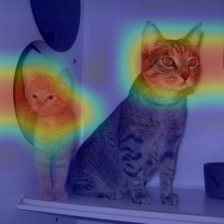

The image classification model likely classified the image as a "cat" due to the presence of two cats in the scene. The saliency map overlaid on the image highlights the areas that are considered important or visually significant. In this case, the two cats are the most prominent objects in the image, occupying a significant portion of the frame. Their distinct features, such as their fur, ears, and eyes, are likely what caught the attention of the model, leading it to classify the image as a "cat." The saliency map helps to understand which parts of the image are most important for the model's decision-making process.


In [12]:
get_explanation(
    "This image was classified as a 'cat' by an image classification model. The overlaid saliency map highlights important regions. Can you explain why these areas might have influenced the classification?",
    f'{protos_path}/prototype-img-original_with_self_act{proto_num}.png'
)

## Comparison to Other Classes

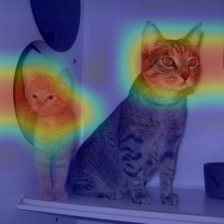

The saliency map in the image shows that the most influential regions are the two cats sitting on the shelf. The saliency map is a visual representation of the image's content, highlighting the areas that are most important or visually striking. In this case, the two cats are the main focus of the image, and their presence is what makes the image a "cat" image.

While it is possible that the saliency map could be interpreted differently, it is unlikely that the same pattern would justify a classification of "dog" since the image primarily features two cats. The saliency map is designed to highlight the most prominent objects or subjects in an image, and in this case, the two cats are the most prominent objects.


In [13]:
get_explanation(
    "This image was classified as a 'cat' and the saliency map shows the most influential regions. Could this same saliency pattern also justify a different classification, such as 'dog'?",
    f'{protos_path}/prototype-img-original_with_self_act{proto_num}.png'
)

## Misclassification Investigation

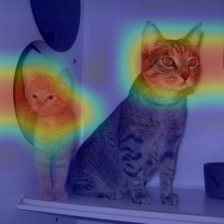

The saliency map highlights certain regions in the image, which can help understand why the model might have misclassified the cat as a dog. The model might have been attracted to the cat's ears, whiskers, or other features that resemble those of a dog. However, the cat's body and overall appearance are more consistent with a cat, so the model's classification is incorrect. The saliency map can provide insights into the model's attention to specific features and help improve its performance in recognizing cats and dogs accurately.


In [14]:
get_explanation(
    "The model classified this as a 'dog,' but the correct label is 'cat.' The saliency map highlights certain regions. Do these highlighted areas suggest why the model made a mistake?",
    f'{protos_path}/prototype-img-original_with_self_act{proto_num}.png'
)

## Counterfactual Explanation

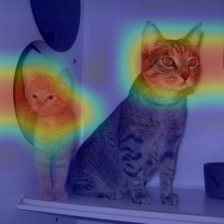

If different areas were highlighted in the saliency map, the classification decision might change depending on the specific areas that are highlighted. In the image, the two cats are sitting next to each other on a shelf, and their positions are highlighted in the saliency map. If the saliency map were to highlight different areas, such as the ears, whiskers, or the eyes of the cats, the classification decision might change to reflect the importance of these features in the image. For example, if the ears were highlighted, the decision might be that the cats are looking at something, while if the whiskers were highlighted, the decision might be that the cats are curious or alert. The saliency map helps to identify the most important features in the image, which can influence the classification decision.


In [15]:
get_explanation(
    "If different areas were highlighted in the saliency map, how might the classification decision change?",
    f'{protos_path}/prototype-img-original_with_self_act{proto_num}.png'
)

## Problem
In typical LLM fasion, giving a bad prompt will result in even worse response. The explainer will make all sorts of leaps of logic trying to justyfiy whatever the prompt is asking for. Taking the first promt from <a href="#BasicExplanation">Basic Explanation</a> and saying the classification was a *dog* instead of a *cat*, will result in the explainer saying there really **is** a dog in the image.

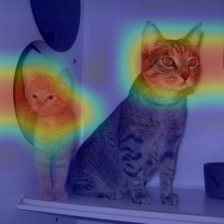

The image classification model might have classified the image as a dog due to the presence of a cat and a dog in the scene. The saliency map highlights the areas that the model considers important, which could be the cat and the dog. The cat is sitting on a shelf next to a bowl, and the dog is also present in the scene. The model might have focused on these animals as the primary subjects of the image, leading to the classification as a dog. However, it is important to note that the model's classification is not always accurate, and it may have made an error in this case.


In [16]:
get_explanation(
    "This image was classified as a 'dog' by an image classification model. The overlaid saliency map highlights important regions. Can you explain why these areas might have influenced the classification?",
    f'{protos_path}/prototype-img-original_with_self_act{proto_num}.png'
)

# Generated Examples

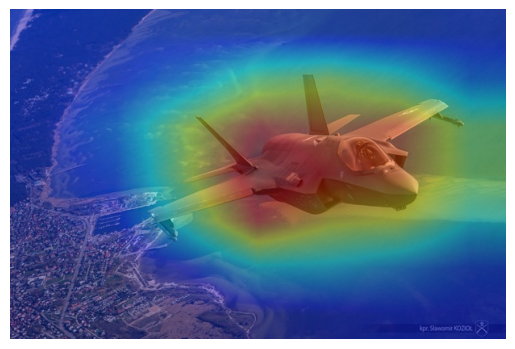

The image classification model might have classified the image as a "military plane" due to the presence of a large, fighter jet-like aircraft flying over the ocean. The jet's size, shape, and position in the sky suggest that it is a military aircraft, which is designed for combat and reconnaissance missions. The saliency map overlaid on the image highlights the areas that the model considers important, which in this case, are the jet and the ocean. The jet's prominent position in the sky and its distinctive appearance are likely the factors that contributed to the classification of the image as a "military plane."


In [17]:
get_explanation(
    "This image was classified as a 'military plane' by an image classification model. The overlaid saliency map highlights important regions. Can you explain why these areas might have influenced the classification?",
    f'./images/generated/f35.png'
)

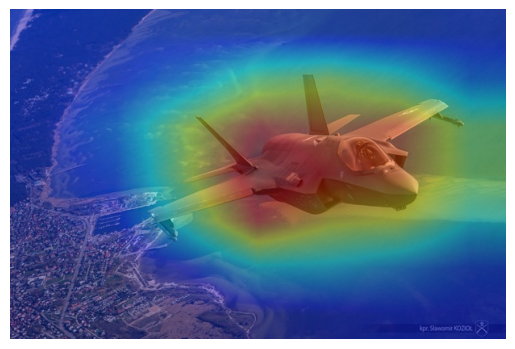

In the saliency map, the jet fighter is the most prominent object, occupying a large portion of the image. If different areas were highlighted, the classification decision might change depending on the specific areas that were emphasized. For example, if the map focused on the surrounding landscape, such as the beach, the jet fighter might be less prominent, and the classification decision might shift towards the natural environment. On the other hand, if the map highlighted the jet fighter's wings or other distinctive features, the classification decision might remain the same, as the jet fighter would still be the most prominent object in the image. The saliency map's purpose is to identify the most important objects in the image, so the classification decision would be influenced by the areas that are emphasized in the map.


In [18]:
get_explanation(
    "If different areas were highlighted in the saliency map, how might the classification decision change?",
    f'./images/generated/f35.png'
)

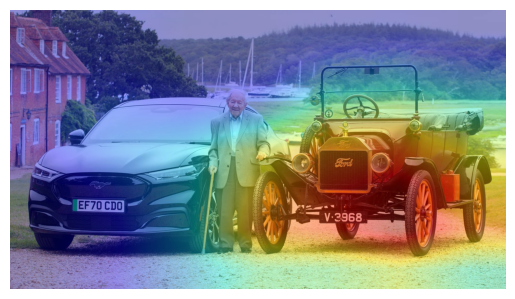

The image classification model might have classified the image as a "model t" due to the presence of an old-fashioned car, which is a classic representation of the early automobile era. The car in the image is a vintage model T, which is a well-known and iconic car from the early 20th century. The saliency map highlights the areas of the image that the model considers important, which in this case, include the old car and the man standing next to it. The presence of the man and the old car together in the image might have influenced the classification, as it suggests a connection between the man and the car, possibly indicating that the man is the owner or a fan of vintage automobiles.


In [20]:
get_explanation(
    "This image was classified as a 'model t' by an image classification model. The overlaid saliency map highlights important regions. Can you explain why these areas might have influenced the classification?",
    f'./images/generated/model t.png'
)

The explanation focused a little to much on the context, and not the facts. The old man's proclivities are not important. 

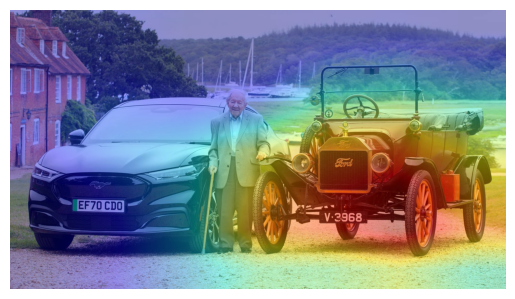

In the saliency map, the car and the old-fashioned car are the most prominent objects, with the car being the most salient object. If different areas were highlighted, the classification decision might change depending on the specific areas that were emphasized. For example, if the saliency map focused on the old-fashioned car, it would be considered the most salient object, and the car would be considered less salient. Conversely, if the saliency map focused on the car, it would be considered the most salient object, and the old-fashioned car would be considered less salient. The classification decision would depend on the specific areas that were emphasized in the saliency map, and it would not be solely based on the overall brightness or color of the objects.


In [21]:
get_explanation(
    "If different areas were highlighted in the saliency map, how might the classification decision change?",
    f'./images/generated/model t.png'
)

## Same-y explanations
The explanations the LLaVA was generating, all have been following the same-ish structure. Let's crank up the temp

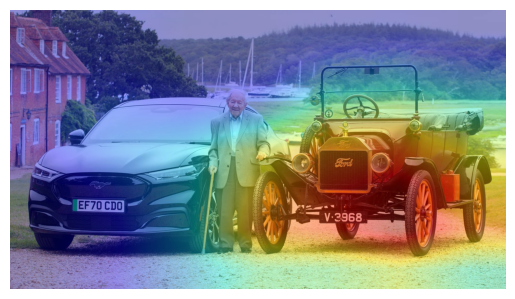

The image classification model might have classified the image as a "model t" due to the presence of an old-fashioned car, which is a classic representation of a Model T Ford, and the fact that the man is standing next to it. The Model T Ford is a significant historical vehicle, and the image might have captured a scene where the man is admiring or interacting with the car. The saliency map highlights important regions, such as the man and the car, which might have influenced the classification due to their prominent presence and the context of the scene.


In [25]:
get_explanation(
    "This image was classified as a 'model t' by an image classification model. The overlaid saliency map highlights important regions. Can you explain why these areas might have influenced the classification?",
    f'./images/generated/model t.png',
    temperature=0.7
)

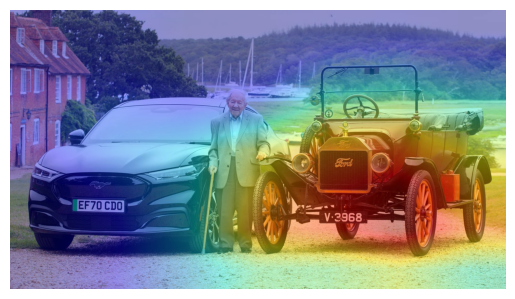

In the saliency map, the car and the old-fashioned car are the most salient objects, while the man and the other cars are less prominent. If different areas were highlighted, the classification decision might change to emphasize the importance of the man and the other cars, as they are more prominent in the image. This would lead to a more accurate representation of the scene and the people present in it. However, it is important to note that the saliency map is a subjective representation of the image and might not always accurately capture the true importance of all objects in the scene.


In [23]:
get_explanation(
    "If different areas were highlighted in the saliency map, how might the classification decision change?",
    f'./images/generated/model t.png',
    temperature = 0.7
)

### Wait a sec... It can't decide

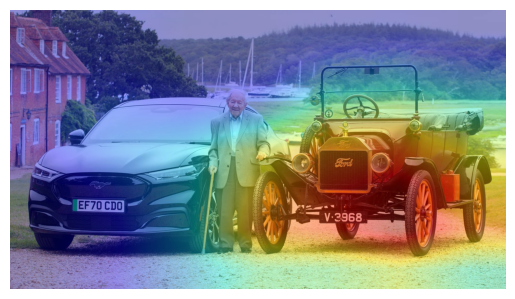

The image classification model likely classified the car as a Model T due to the presence of an older, classic-looking car in the scene. The Model T was a groundbreaking car that revolutionized the automotive industry and transportation in the early 20th century. The car in the image appears to be a vintage or classic car, which is reminiscent of the Model T. The presence of a man standing next to the car further supports the notion that it could be a classic car, as it might be a popular attraction or a point of interest in the area. The saliency map highlights the car and the man as the most important regions in the image, emphasizing their significance in the classification process.


In [28]:
get_explanation(
    "This image was classified as a 'model t' by an image classification model. The overlaid saliency map highlights important regions. Can you explain why these areas might have influenced the classification?",
    f'./images/generated/model t.png',
    temperature=0.7
)

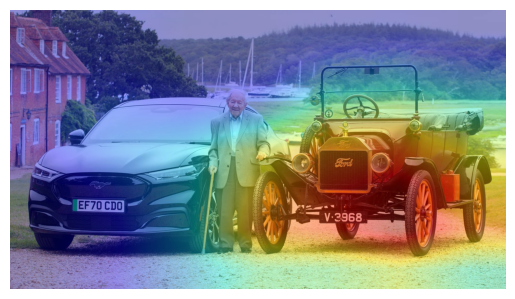

In the image, the saliency map highlights different areas, such as the old-fashioned car, the man, the black car, and the surrounding environment. If the classification decision were based on these highlighted areas, the car would be the primary object of interest, as it is the main focus of the image. The man and the old-fashioned car would be the most prominent subjects, with the black car and the surrounding environment playing a secondary role. This classification decision would emphasize the man's interaction with the old-fashioned car and the context of the scene, rather than focusing on the black car's presence.


In [29]:
get_explanation(
    "If different areas were highlighted in the saliency map, how might the classification decision change?",
    f'./images/generated/model t.png',
    temperature = 0.7
)

When given the `basic explanation` prompt multiple times, it seems the model can't really decide whether the old man is important or not. Due to proximity of one another, the sailency map bleeds slightly onto the man, seamingly giving him some importance, resulting in the explainer **sometimes** including him in the explanations, and sometimes not.

# Multiple labels in one image

## Counterfactual explanations

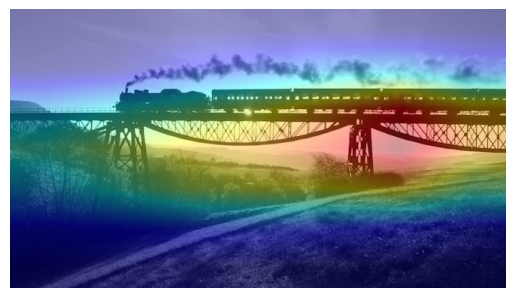

The saliency map in the image highlights the train and the bridge as the most prominent features. However, the model misclassified the image as a 'steel arch bridge' instead of a 'steam locomotive'. This suggests that the model might have focused too much on the train and the bridge, and not paid enough attention to the actual object in the image, which is the steam locomotive. The model's mistake could be due to the fact that the train and the bridge are the most visually striking elements in the image, and the model might have been influenced by their presence while making the classification. This highlights the importance of considering multiple visual cues and not being solely reliant on a single prominent feature when classifying an image.


In [35]:
get_explanation(
    "The model classified this as a 'steel arch bridge', but the correct label is 'steam locomotive'. The saliency map highlights certain regions. Do these highlighted areas suggest why the model made a mistake?",
    f'./images/generated/bridge 2.png',
    temperature = 0.7
)

> focused too much on the **train** and the bridge, and not paid enough attention to the actual object in the image, which is the **steam locomotive**.

While technically not incorrect, I don't think this response is interpretable enough - it is slightly confusing. The temperature might be too high.

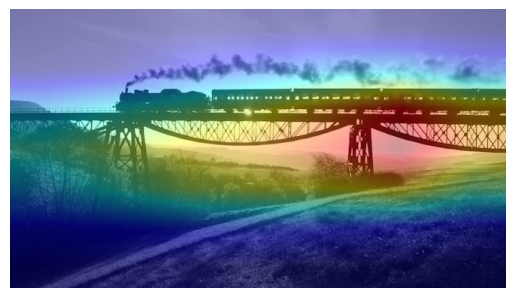

The saliency map highlights the train and the bridge, which are the main objects in the image. The model might have misclassified the image as a 'steel arch bridge' due to the presence of the train and the bridge, which are the most prominent features in the image. The model might have focused on these objects and overlooked the fact that the train is a steam locomotive, which is a type of train that uses steam power. The model's classification error could be attributed to the limited context provided by the image, as it does not explicitly show the nature of the train's power source.


In [36]:
get_explanation(
    "The model classified this as a 'steel arch bridge', but the correct label is 'steam locomotive'. The saliency map highlights certain regions. Do these highlighted areas suggest why the model made a mistake?",
    f'./images/generated/bridge 2.png'
)

I kinda like this one 👍

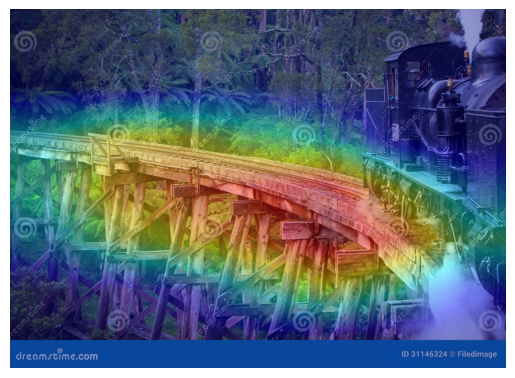

The saliency map highlights the steam locomotive, which is a train, and the bridge, which is a man-made structure. The model might have mistakenly classified the image as a 'steel arch bridge' due to the presence of the train and the bridge, which are the most prominent features in the image. The model might have focused on these two objects and overlooked the train as the primary subject, leading to the incorrect classification. This highlights the importance of considering the context and the actual content of an image when applying machine learning models to classify and analyze visual content.


In [37]:
get_explanation(
    "The model classified this as a 'steel arch bridge', but the correct label is 'steam locomotive'. The saliency map highlights certain regions. Do these highlighted areas suggest why the model made a mistake?",
    f'./images/generated/bridge.png'
)

None of these explanations pointed out the fact, that neither of these bridges are **steel arch bridges**. The first picutre is a truss bridge, and te second one is made out of wood (and is not an arch bridge).

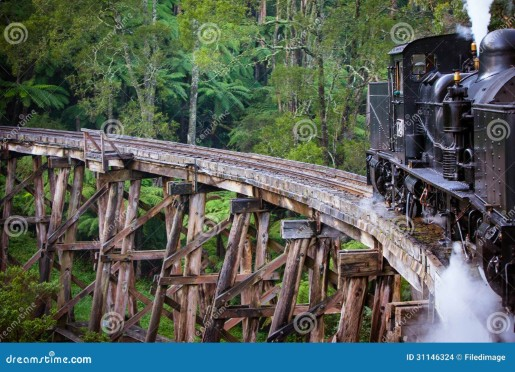

The model might have made this mistake due to the presence of a steam locomotive in the image, which could have led to confusion between the two concepts. The steam locomotive is a type of train that uses steam power, while the bridge is a structure designed for transportation purposes. The model might have focused on the steam locomotive and mistakenly associated it with the bridge, leading to the incorrect label. It is essential to pay close attention to the context and details of an image to accurately classify and label objects or concepts.


In [49]:
get_explanation(
    "The model classified this as a 'steel arch bridge', but the correct label is 'steam locomotive'. Why would the model make this mistake?",
    f'./images/generated/loco.jpg'
)

-----

## Different approach

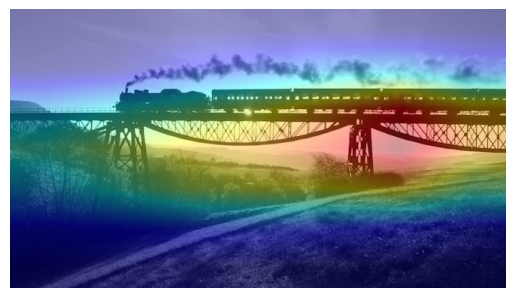

The model classified the image as a "steel arch bridge" because it detected the presence of a bridge structure in the image. The saliency map highlights the regions that influenced the model the most, which in this case, are the bridge and the train. The model's focus on these elements is due to their distinct features and the fact that they are the most prominent objects in the image. The presence of a train, specifically a steam locomotive, is another reason the model classified the image as "steam locomotive." The model is trained to recognize and classify objects based on their visual features, and in this case, it has identified the train as a steam locomotive due to its distinctive appearance and the fact that it is the most prominent object in the image.


In [44]:
get_explanation(
    "The model classified this as a 'steel arch bridge', but 'steam locomotive' would also be a correct label. The saliency map highlights regions that influenced the model the most. Why did the model classified the image as such?",
    f'./images/generated/bridge 2.png'
)

> the model classified the image as "steam locomotive."

A better prompt might be needed.

### Prompt generated by ChatGPT

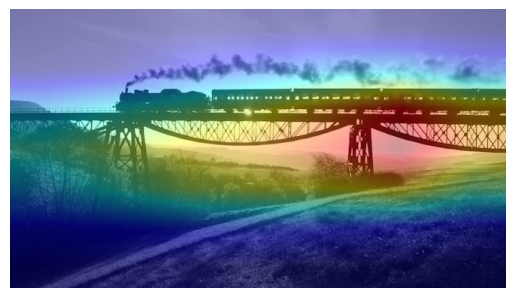

The model prioritized 'steel arch bridge' over 'steam locomotive' because the image primarily features a large, colorful bridge with a train passing underneath it. The bridge's distinctive structure and vibrant colors are more prominent in the image, making it the most salient object. The train, although present, is not as prominent or visually striking as the bridge, so it is less likely to be the primary focus of the image. The model's decision-making process is based on the visual features that are most prominent and easily identifiable, leading to the classification of the image as a 'steel arch bridge' rather than a 'steam locomotive.'


In [47]:
get_explanation(
    "The model classified this image as a 'steel arch bridge,' but 'steam locomotive' could also be a valid label. The saliency map highlights the most influential regions in the model's decision-making process. Explain why the model prioritized 'steel arch bridge' over 'steam locomotive' and describe the key visual features that led to this classification.",
    f'./images/generated/bridge 2.png'
)

What colors? It misunderstands the sailency map, as the paint on the bridge?